In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import os
import statsmodels.api as sm
import warnings
import matplotlib.pyplot as plt
import math
from pandas import Series
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from keras.models import Model, Sequential
from keras.layers import GRU, Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import seaborn as sns
from statsmodels.tsa.stattools import adfuller

C:\Users\Kushal\Anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Kushal\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\Kushal\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\Kushal\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
data = pd.read_excel('C:/Users/Kushal/Desktop/Energy forecasting/GEFCom2014 Data/GEFCom2014-E_V2/GEFCom2014-E.xlsx',sheet_name='Hourly')
data = data.dropna()
data.Date +=  pd.to_timedelta(data.Hour, unit='h')
data = data.set_index('Date')
ts_data = data.copy()
ts_data = ts_data[['load','T']]
ts_data_load = ts_data['load']
ts_data.dtypes


load    float64
T       float64
dtype: object

In [3]:
ts_data.describe()

,load,T
count,78888.000000,78888.000000
mean,3308.000837,47.573928
std,579.803021,19.201312
min,1811.000000,-18.000000
25%,2845.000000,32.666667
50%,3382.000000,48.666667
75%,3709.000000,63.000000
max,5506.000000,97.000000


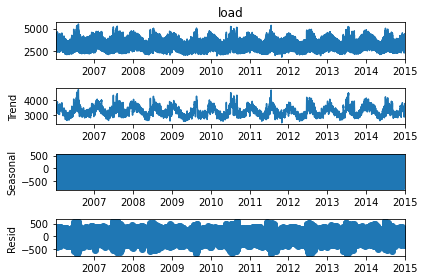

In [4]:
decomposition = sm.tsa.seasonal_decompose(ts_data_load, model = 'additive')
fig = decomposition.plot()

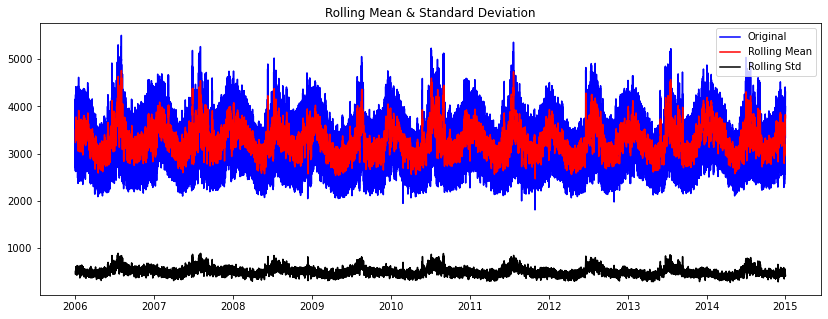

<Results of Dickey-Fuller Test>
Test Statistic                -1.642843e+01
p-value                        2.491795e-29
#Lags Used                     6.400000e+01
Number of Observations Used    7.882300e+04
Critical Value (1%)           -3.430433e+00
Critical Value (5%)           -2.861577e+00
Critical Value (10%)          -2.566790e+00
dtype: float64


In [5]:
def test_stationarity(timeseries):
    rolmean = timeseries.rolling(window=30).mean()
    rolstd = timeseries.rolling(window=30).std()
    
    plt.figure(figsize=(14,5))
    sns.despine(left=True)
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')

    plt.legend(loc='best'); plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    print ('<Results of Dickey-Fuller Test>')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    
test_stationarity(ts_data_load.dropna())

In [6]:
dataset = ts_data['load'].values #numpy.ndarray
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)




In [7]:
valid_st_data_load = '2012-01-01 00:00:00'
test_st_data_load = '2014-01-01 00:00:00'

# train
train = pd.DataFrame(ts_data_load.copy()[ts_data_load.index < test_st_data_load])#[['load']]
train = train['load'].values
train = train.astype('float32')
train = np.reshape(train, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
train = scaler.fit_transform(train)

# valid
valid = pd.DataFrame(ts_data_load.copy().loc[(ts_data_load.index >= valid_st_data_load) &
                                             (ts_data_load.index < test_st_data_load)])  #[['load']]
valid = valid['load'].values
valid = valid.astype('float32')
valid = np.reshape(valid, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
valid = scaler.fit_transform(valid)

# test
test = pd.DataFrame(ts_data_load.copy().loc[(ts_data_load.index >= test_st_data_load)])  #[['load']]
test = test['load'].values
test = test.astype('float32')
test = np.reshape(test, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
test = scaler.fit_transform(test)


In [8]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)



# reshape into X=t and Y=t+1
look_back = 30
X_train, Y_train = create_dataset(train, look_back)
X_valid, Y_valid = create_dataset(valid, look_back)
X_test, Y_test = create_dataset(test, look_back)


print(X_train.shape)
print(Y_train.shape)

(70096, 30)
(70096,)


In [9]:
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_valid = np.reshape(X_valid, (X_valid.shape[0], 1, X_valid.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

X_train.shape

(70096, 1, 30)

In [10]:
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(X_train, Y_train, epochs=20, batch_size=70, validation_data=(X_valid, Y_valid), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)
# Training Phase
model.summary()

Epoch 1/20
1002/1002 [==============================] - 22s 4ms/step - loss: 0.0107 - val_loss: 9.9242e-04
Epoch 2/20
1002/1002 [==============================] - 3s 3ms/step - loss: 0.0013 - val_loss: 6.3501e-04
Epoch 3/20
1002/1002 [==============================] - 3s 3ms/step - loss: 9.4425e-04 - val_loss: 4.9064e-04
Epoch 4/20
1002/1002 [==============================] - 3s 3ms/step - loss: 7.4596e-04 - val_loss: 3.9250e-04
Epoch 5/20
1002/1002 [==============================] - 3s 3ms/step - loss: 5.9324e-04 - val_loss: 4.3051e-04
Epoch 6/20
1002/1002 [==============================] - 3s 3ms/step - loss: 5.0438e-04 - val_loss: 5.6855e-04
Epoch 7/20
1002/1002 [==============================] - 3s 3ms/step - loss: 4.4308e-04 - val_loss: 4.5225e-04
Epoch 8/20
1002/1002 [==============================] - 3s 3ms/step - loss: 3.9694e-04 - val_loss: 2.8673e-04
Epoch 9/20
1002/1002 [==============================] - 3s 3ms/step - loss: 3.5802e-04 - val_loss: 2.2530e-04
Epoch 10/20
1002/

Train Mean Absolute Error: 30.850842609254663
Train Root Mean Squared Error: 40.03458914989142
valid Mean Absolute Error: 31.81932947506291
valid Root Mean Squared Error: 41.68309847742129
R2: 0.9934874415276744


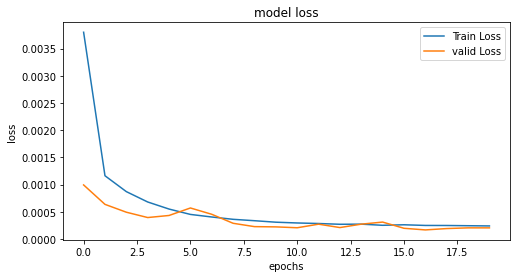

In [11]:
# make predictions
train_predict = model.predict(X_train)
valid_predict = model.predict(X_valid)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
valid_predict = scaler.inverse_transform(valid_predict)
Y_train = scaler.inverse_transform([Y_train])
Y_valid = scaler.inverse_transform([Y_valid])

print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('valid Mean Absolute Error:', mean_absolute_error(Y_valid[0], valid_predict[:,0]))
print('valid Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_valid[0], valid_predict[:,0])))
print('R2:', r2_score(Y_valid[0], valid_predict[:,0]))

plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='valid Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

In [12]:
test_predict = model.predict(X_test)
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))
print('R2:', r2_score(Y_test[0], test_predict[:,0]))

Train Mean Absolute Error: 30.850842609254663
Train Root Mean Squared Error: 40.03458914989142
test Mean Absolute Error: 33.18173169109719
test Root Mean Squared Error: 43.8529467871076
R2: 0.9935981851837317


         actual      predict
0   3468.999911  3417.515625
1   3869.000100  3708.479980
2   4124.000160  4051.938721
3   4241.000130  4216.834961
4   4359.000105  4293.736328
5   4421.000110  4391.720703
6   4474.000064  4432.224121
7   4461.999995  4482.590332
8   4467.000024  4429.992676
9   4452.999944  4418.966797
10  4438.999864  4503.264648
11  4669.000130  4684.700684
12  4877.999927  4867.289551
13  4806.999871  4812.464844
14  4641.999976  4623.386719
15  4469.000035  4441.423340
16  4180.000131  4176.345703
17  3872.000117  3836.728027
18  3613.000035  3624.248779
19  3458.999853  3467.949219


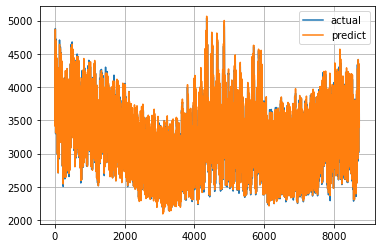

In [15]:
actual = pd.DataFrame(Y_test[0])
predict = pd.DataFrame(test_predict[:,0])
final = pd.concat([actual,predict.astype(float)],axis=1)
final.columns = ['actual','predict']

print(final.head(20))

plt.figure()
plt.plot(actual, label='actual')
plt.plot(predict, label='predict')
plt.grid()
plt.legend()


In [21]:
def mape(ts_predictions, actuals):
    """Mean absolute percentage error"""
    return (abs(ts_predictions - actuals) / actuals).mean()


print('MAPE',mape(final["predict"], final["actual"]))


print('DIFFERENCE IN VALUES <= 200:',len(final[abs(final['actual']-final['predict'])<=200])/len(final))

MAPE 0.010029793153099249
DIFFERENCE IN VALUES <= 200: 0.9996563573883162
